### Metric Learning and Plotting

This is a small walkthrough which illustrates all the Metric Learning algorithms implemented in metric_learn, and also does a quick visualisation which can help understand which algorithm might be best suited for you.

Of course, depending on the data set and the constraints your results will look very different; you can just follow this and change your data and constraints accordingly.

### Imports 

In [1]:
%matplotlib inline

import metric_learn
import numpy as np
from sklearn.datasets import load_iris

# visualisation imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Loading our data-set and setting up plotting

In [2]:
# loading our dataset

iris_data = load_iris()
# this is our data
X = iris_data['data']
# these are our constraints
Y = iris_data['target']

# function to plot the results

def plot(X, Y):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

    # 
    plt.figure(2, figsize=(8, 6))

    # clean the figure
    plt.clf()

    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())

    plt.show()

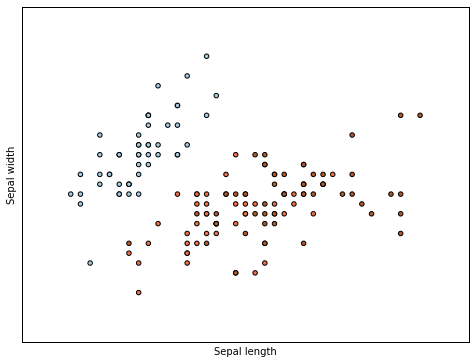

In [3]:
# plotting the dataset as is.
plot(X, Y)

### Applying Large Margin Nearest Neighbour

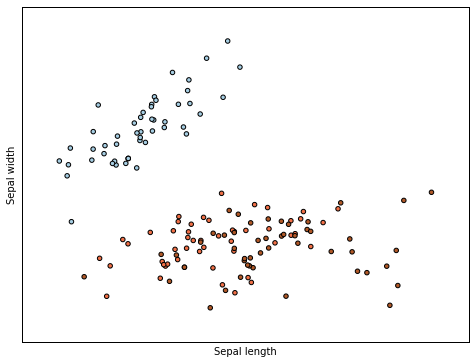

In [4]:
# applying our Metric Learned algorithm
X = iris_data['data']
lmnn = metric_learn.LMNN(k=5, learn_rate=1e-6)
lmnn.fit(X, Y)
X = lmnn.transform()

plot(X, Y)

### Applying Information Theoretic Metric Learning 

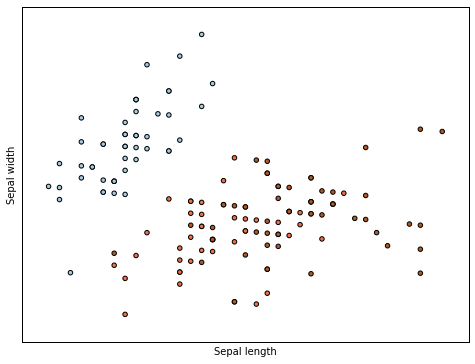

In [5]:
X = iris_data['data']
itml = metric_learn.ITML_Supervised(num_constraints=200)
itml.fit(X, Y)
X = itml.transform()

plot(X, Y)

### Applying Sparse Determinant Metric Learning

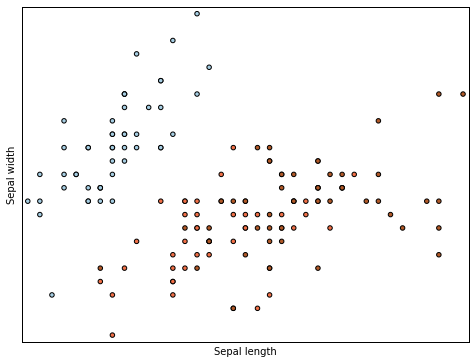

In [6]:
X = iris_data['data']
sdml = metric_learn.SDML_Supervised(num_constraints=200)
sdml.fit(X, Y)
X = sdml.transform()

plot(X, Y)

### Applying Least Squares Metric Learning

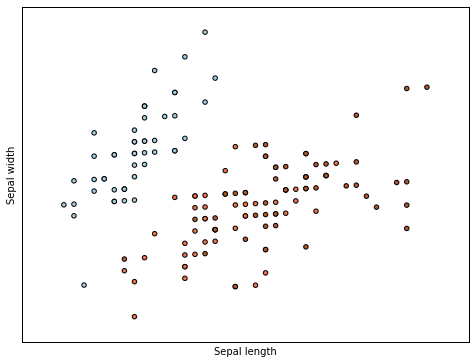

In [7]:
X = iris_data['data']
lsml = metric_learn.LSML_Supervised(num_constraints=200)
lsml.fit(X, Y)
X = lsml.transform()

plot(X, Y)

### Applying Neighborhood Components Analysis

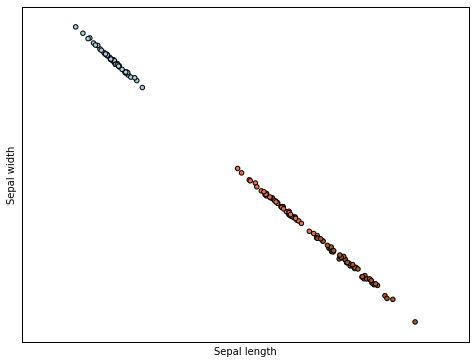

In [8]:
X = iris_data['data']
nca = metric_learn.NCA(max_iter=1000, learning_rate=0.01)
nca.fit(X, Y)
X = nca.transform()

plot(X, Y)

### Applying Local Fischer Discriminant Analysis

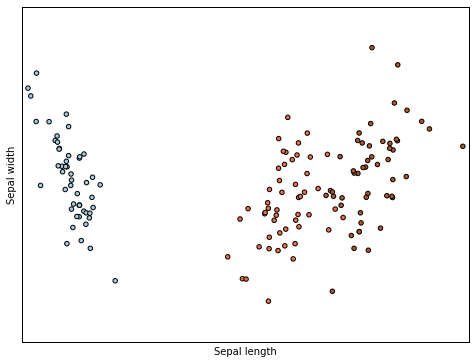

In [9]:
X = iris_data['data']
lfda = metric_learn.LFDA(k=2, dim=2)
lfda.fit(X, Y)
X = lfda.transform()

plot(X, Y)

### Applying Relative Components Analysis

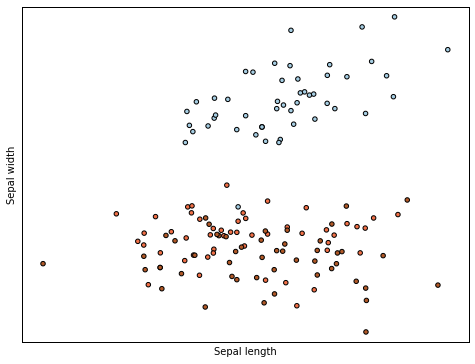

In [10]:
X = iris_data['data']
rca = metric_learn.RCA_Supervised(num_chunks=30, chunk_size=2)
rca.fit(X, Y)
X = rca.transform()

plot(X, Y)